In [1]:
import numpy as np
import pandas as pd
from indigo import *
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'
from bokeh.io import output_notebook

In [2]:
output_notebook()

Loading BokehJS ...

### Some global variables used throughout this notebook

In [3]:
PATH = "Adrenergic_dataset.csv"
FOLDS = 5
SEED = 12
ASSAY =  "AdrA1A_PCHEMBL_VALUE"
#ASSAY =  "logP"

columns = ["Structure", "ID", ASSAY]

### Read data from csv

In [4]:
df = pd.read_csv(PATH)
df.head()

,Structure,ID,logP,Vx,MW,NegativeCharge,PositiveCharge,Flex,AromaticRings,OverallCharge,...,q485,frg-8,frg-26,frg-54,Nn,AdrA1A_PCHEMBL_VALUE,AdrA1B_PCHEMBL_VALUE,AdrA1D_PCHEMBL_VALUE,AdrA2A_PCHEMBL_VALUE,AdrA2C_PCHEMBL_VALUE
0,CC\C(=C(\CC)/c1ccc(O)cc1)\c2ccc(O)cc2,CHEMBL411,4.871,224.4,268.4,0,0,0.1905,2,0,...,4,2,0,0,0,NaN,NaN,NaN,NaN,5.66
1,CSc1ccc2Sc3ccccc3N(CCC4CCCCN4C)c2c1,CHEMBL479,5.900,290.2,370.6,0,2,0.1429,2,2,...,18,0,0,0,2,NaN,NaN,NaN,NaN,7.60
2,COc1cccc(CCN2C3C4C5CC6C7C5C3C7C2(O)C46)c1,CHEMBL2205811,3.040,225.5,309.4,0,1,0.1379,1,1,...,4,0,0,0,1,NaN,NaN,NaN,NaN,6.25
3,COc1cc(CN[C@H]2C3C4CC5C6C4CC3C6C25)cc(OC)c1OC,CHEMBL2432051,3.380,256.3,341.4,0,1,0.2000,1,1,...,8,0,0,0,1,NaN,NaN,NaN,NaN,5.64
4,COc1cccc(CCN2C3C4C5CC6C7C5C3C7C2(O)C46)c1OC,CHEMBL2205813,2.899,245.4,339.4,0,1,0.1613,1,1,...,6,0,0,0,1,NaN,NaN,NaN,NaN,5.36


### Drop NA values from assay value column

In [5]:
dataset = df[columns]
dataset.dropna(subset=[ASSAY], inplace=True)

In [6]:
indigo = Indigo()


def get_fingerprints(
    dataset: pd.DataFrame, 
    ignore_stereochemistry_errors: bool = True,
    ignore_bad_valence: bool = True,
    similarity_type: str = "ecfp6", # "ecfp4", "ecfp6", "ecfp8", "sim", "chem"
    fp_sim_qwords: int = 8,
    fp_ord_qwords: int = 25,
    fp_any_qwords: int = 15,
    fp_tau_qwords: int = 25,
    fp_ext_enabled: bool = True
):
    indigo.setOption("ignore-stereochemistry-errors", ignore_stereochemistry_errors)
    indigo.setOption("ignore-bad-valence", ignore_bad_valence)
    indigo.setOption("similarity-type", similarity_type)
    indigo.setOption("fp-sim-qwords", fp_sim_qwords)
    indigo.setOption("fp-ord-qwords", fp_ord_qwords)
    indigo.setOption("fp-any-qwords", fp_any_qwords)
    indigo.setOption("fp-tau-qwords", fp_tau_qwords)
    indigo.setOption("fp-ext-enabled", fp_ext_enabled)
    fingerprints = []
    max_val = -np.Inf

    for struct in dataset["Structure"]:
        mol = indigo.loadMolecule(struct)
        mol.aromatize()
        fingerprint = mol.fingerprint("full").toBuffer()
        buffered = np.frombuffer(fingerprint, dtype=np.uint8)
        buffered = np.unpackbits(buffered)
        fingerprints.append(buffered)
        max_val = max(max_val, *buffered)

    fingerprints = np.array(fingerprints, dtype=np.float32) / max_val
    return fingerprints


fingerprints = get_fingerprints(dataset)
dataset.head()

,Structure,ID,AdrA1A_PCHEMBL_VALUE
7,CNC(=O)C(CCN1CCC(O)(CC1)c2ccc(Cl)cc2)(c3ccccc3...,CHEMBL1627,8.00
12,Cc1ccc2c(cccc2n1)N3CCN(CCc4cccc5c4OCc6c(ncn56)...,CHEMBL1241913,8.56
13,COc1ccccc1OCCNCC2CSC(S2)(c3ccccc3)c4ccccc4,CHEMBL1086156,7.45
16,O[C@H]1[C@H](CC[C@@H]1Oc2ccccc2)NC[C@H]3COc4cc...,CHEMBL135974,6.41
19,COc1cccc(OC)c1OCCNC[C@H]2COc3ccccc3O2,CHEMBL1182155,9.39


### Draw distribution plot for assay values

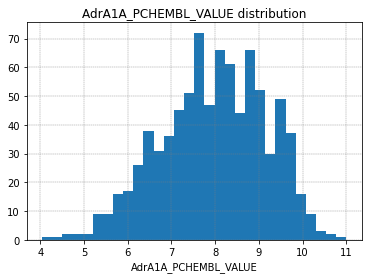

In [7]:
def build_histogram(input, title: str = ''):
    x = input
    n, bins, patches = plt.hist(x, 30)

    #plt.style.use('classic')
    plt.xlabel(title)
    plt.title(f'{title} distribution')
    plt.grid(True, color = "grey", linewidth = "0.4", linestyle = "dashed")
    plt.show()

build_histogram(input=dataset[ASSAY], title=ASSAY)

## Out-of-fold $r^2$ score estimations on train, validation and test datasets

### Random Forest Regression

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from utils.folds import oof


bundle = train_test_split(fingerprints, dataset, shuffle=True, random_state=SEED, test_size=0.25)

y_test = bundle[3]

model = RandomForestRegressor(n_estimators=100, max_features=0.2, max_depth=12, min_samples_leaf=2)
errors, y_pred = oof(model, bundle, assay=ASSAY)

MEAN TRAIN:  0.8884084001862173
MEAN VALIDATION:  0.49331155855831244
MEAN TEST 0.536787781934217


### Fingerprints optimization

In [10]:
import optuna

In [20]:
class FingerprintObjective(object):
    def __init__(self, dataset):
        self.dataset = dataset

    def __call__(self, trial):
        trials_dict = {
            #"ignore_stereochemistry_errors": trial.suggest_categorical("ignore_stereochemistry_errors", [0, 1]),
            #"ignore_bad_valence": trial.suggest_categorical("ignore_bad_valence", [0, 1]),
            "similarity_type": trial.suggest_categorical("similarity_type", ["ecfp4", "ecfp6", "ecfp8", "sim", "chem"]),
            "fp_sim_qwords": trial.suggest_int("fp_sim_qwords", 1, 32),
            "fp_ord_qwords": trial.suggest_int("fp_ord_qwords", 1, 32), #int = 25,
            "fp_any_qwords": trial.suggest_int("fp_any_qwords", 1, 32), #,int = 15,
            "fp_tau_qwords": trial.suggest_int("fp_tau_qwords", 1, 32), #int = 25,
            "fp_ext_enabled": trial.suggest_categorical("fp_ext_enabled", [0, 1]) #bool = True
        }
        
        # rf_trial_dict = {
        #     "max_depth": trial.suggest_int('rf_max_depth', 2, 200, log=True),
        #     "min_samples_leaf": trial.suggest_int('rf_min_samples_leaf', 2, 200),
        #     "n_estimators": trial.suggest_int('rf_estimators', 2, 200),
        #     "max_features": trial.suggest_float('rf_max_feats', 0.1, 0.9)
        # }
    

        fingerprints = get_fingerprints(self.dataset, **trials_dict)
        bundle = train_test_split(fingerprints, dataset, shuffle=True, random_state=SEED, test_size=0.25)

        y_test = bundle[3]

        model = RandomForestRegressor(n_estimators=100, max_features=0.2, max_depth=12, min_samples_leaf=2)
        errors, y_pred = oof(model, bundle, assay=ASSAY)
        return np.mean(errors)


pruner = optuna.pruners.SuccessiveHalvingPruner()
sampler = optuna.samplers.NSGAIISampler(population_size=200)
study = optuna.create_study(direction='maximize', pruner=pruner, sampler=sampler)
study.optimize(FingerprintObjective(dataset), n_trials=1024)

[I 2022-01-25 21:19:35,176] A new study created in memory with name: no-name-a45a77e4-b3cd-4882-97b9-31c9c1b3cc47
[I 2022-01-25 21:19:56,925] Trial 0 finished with value: 0.5141970024642724 and parameters: {'similarity_type': 'sim', 'fp_sim_qwords': 20, 'fp_ord_qwords': 7, 'fp_any_qwords': 25, 'fp_tau_qwords': 23, 'fp_ext_enabled': 0}. Best is trial 0 with value: 0.5141970024642724.


MEAN TRAIN:  0.7808656048199475
MEAN VALIDATION:  0.4592234701302959
MEAN TEST 0.5141970024642724


[I 2022-01-25 21:20:13,010] Trial 1 finished with value: 0.4894767190287947 and parameters: {'similarity_type': 'sim', 'fp_sim_qwords': 26, 'fp_ord_qwords': 4, 'fp_any_qwords': 11, 'fp_tau_qwords': 21, 'fp_ext_enabled': 1}. Best is trial 0 with value: 0.5141970024642724.


MEAN TRAIN:  0.7710389883393142
MEAN VALIDATION:  0.45000418600695663
MEAN TEST 0.4894767190287947


[I 2022-01-25 21:20:28,222] Trial 2 finished with value: 0.5305568566760961 and parameters: {'similarity_type': 'ecfp6', 'fp_sim_qwords': 3, 'fp_ord_qwords': 18, 'fp_any_qwords': 2, 'fp_tau_qwords': 17, 'fp_ext_enabled': 1}. Best is trial 2 with value: 0.5305568566760961.


MEAN TRAIN:  0.8028325406135284
MEAN VALIDATION:  0.45535632333266074
MEAN TEST 0.5305568566760961


[I 2022-01-25 21:20:52,874] Trial 3 finished with value: 0.5357259914113583 and parameters: {'similarity_type': 'ecfp8', 'fp_sim_qwords': 30, 'fp_ord_qwords': 17, 'fp_any_qwords': 3, 'fp_tau_qwords': 30, 'fp_ext_enabled': 0}. Best is trial 3 with value: 0.5357259914113583.


MEAN TRAIN:  0.8003639215447402
MEAN VALIDATION:  0.4630974928228976
MEAN TEST 0.5357259914113583


[I 2022-01-25 21:21:04,142] Trial 4 finished with value: 0.5197886043961971 and parameters: {'similarity_type': 'ecfp6', 'fp_sim_qwords': 2, 'fp_ord_qwords': 14, 'fp_any_qwords': 12, 'fp_tau_qwords': 1, 'fp_ext_enabled': 1}. Best is trial 3 with value: 0.5357259914113583.


MEAN TRAIN:  0.8007600143077379
MEAN VALIDATION:  0.4641615302451457
MEAN TEST 0.5197886043961971


[I 2022-01-25 21:21:15,558] Trial 5 finished with value: 0.5156348677151109 and parameters: {'similarity_type': 'ecfp8', 'fp_sim_qwords': 15, 'fp_ord_qwords': 9, 'fp_any_qwords': 6, 'fp_tau_qwords': 1, 'fp_ext_enabled': 0}. Best is trial 3 with value: 0.5357259914113583.


MEAN TRAIN:  0.7859423503429511
MEAN VALIDATION:  0.4585105469326266
MEAN TEST 0.5156348677151109


[I 2022-01-25 21:21:48,264] Trial 6 finished with value: 0.5235368379958277 and parameters: {'similarity_type': 'ecfp6', 'fp_sim_qwords': 32, 'fp_ord_qwords': 21, 'fp_any_qwords': 28, 'fp_tau_qwords': 18, 'fp_ext_enabled': 1}. Best is trial 3 with value: 0.5357259914113583.


MEAN TRAIN:  0.8038623861076569
MEAN VALIDATION:  0.4890656491789883
MEAN TEST 0.5235368379958277


[I 2022-01-25 21:22:02,330] Trial 7 finished with value: 0.5286803296621607 and parameters: {'similarity_type': 'ecfp6', 'fp_sim_qwords': 7, 'fp_ord_qwords': 9, 'fp_any_qwords': 7, 'fp_tau_qwords': 12, 'fp_ext_enabled': 0}. Best is trial 3 with value: 0.5357259914113583.


MEAN TRAIN:  0.795520395598761
MEAN VALIDATION:  0.4626778766197064
MEAN TEST 0.5286803296621607


[I 2022-01-25 21:22:28,669] Trial 8 finished with value: 0.5195998175928345 and parameters: {'similarity_type': 'ecfp8', 'fp_sim_qwords': 16, 'fp_ord_qwords': 30, 'fp_any_qwords': 15, 'fp_tau_qwords': 8, 'fp_ext_enabled': 0}. Best is trial 3 with value: 0.5357259914113583.


MEAN TRAIN:  0.8061233821892563
MEAN VALIDATION:  0.4808370212417018
MEAN TEST 0.5195998175928345


[I 2022-01-25 21:22:43,469] Trial 9 finished with value: 0.5298204593349471 and parameters: {'similarity_type': 'ecfp8', 'fp_sim_qwords': 16, 'fp_ord_qwords': 15, 'fp_any_qwords': 8, 'fp_tau_qwords': 3, 'fp_ext_enabled': 0}. Best is trial 3 with value: 0.5357259914113583.


MEAN TRAIN:  0.7961067343593535
MEAN VALIDATION:  0.4604031811234058
MEAN TEST 0.5298204593349471


[I 2022-01-25 21:23:01,836] Trial 10 finished with value: 0.5096157004096191 and parameters: {'similarity_type': 'chem', 'fp_sim_qwords': 16, 'fp_ord_qwords': 9, 'fp_any_qwords': 7, 'fp_tau_qwords': 31, 'fp_ext_enabled': 1}. Best is trial 3 with value: 0.5357259914113583.


MEAN TRAIN:  0.7870711084657241
MEAN VALIDATION:  0.46044512982103586
MEAN TEST 0.5096157004096191


[I 2022-01-25 21:23:22,346] Trial 11 finished with value: 0.5219730523551002 and parameters: {'similarity_type': 'ecfp8', 'fp_sim_qwords': 14, 'fp_ord_qwords': 30, 'fp_any_qwords': 4, 'fp_tau_qwords': 6, 'fp_ext_enabled': 0}. Best is trial 3 with value: 0.5357259914113583.


MEAN TRAIN:  0.8008252571395218
MEAN VALIDATION:  0.47964772014249907
MEAN TEST 0.5219730523551002


[I 2022-01-25 21:23:44,289] Trial 12 finished with value: 0.5311884982809203 and parameters: {'similarity_type': 'ecfp8', 'fp_sim_qwords': 7, 'fp_ord_qwords': 18, 'fp_any_qwords': 4, 'fp_tau_qwords': 30, 'fp_ext_enabled': 0}. Best is trial 3 with value: 0.5357259914113583.


MEAN TRAIN:  0.8063254515271346
MEAN VALIDATION:  0.46170317103505215
MEAN TEST 0.5311884982809203


KeyboardInterrupt: 

### Static plots

In [10]:
from utils.plots import static_avp_avr_graphs, avr_plot, avp_plot

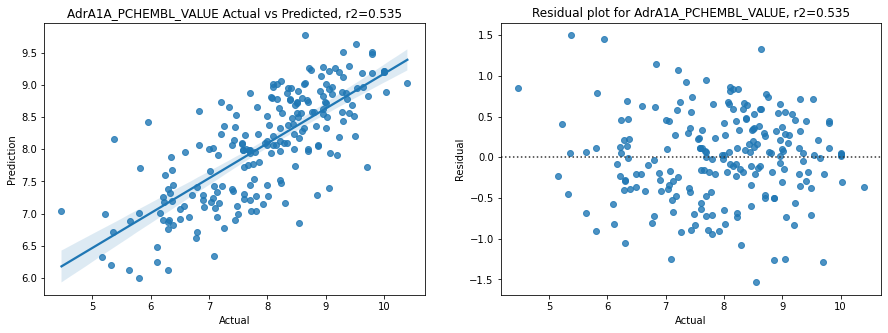

In [11]:
static_avp_avr_graphs(y_pred, y_test[ASSAY], np.mean(errors), ASSAY)

### Interactive plots

In [ ]:
avp_plot(y_test[ASSAY], y_pred, y_test.index.values, y_test["Structure"], np.mean(errors))

In [ ]:
avr = avr_plot(y_test[ASSAY], y_pred, y_test.index.values, y_test["Structure"], np.mean(errors))